In [2]:
%load_ext autoreload
%autoreload 2

import torch

from torch.utils.data import DataLoader

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_split import dagm_patch_get_splits
from src.deep_ad.image import plot_losses, plot_images
from src.deep_ad.model import DeepCNN
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.trainer import Trainer, create_optimizer
from src.deep_ad.transforms import create_training_transform, create_validation_transform

In [3]:
# Load the configuration
config = Config(root_dir='..')

### Test the trainer

In [4]:
# Load the datasets
train_transform = create_training_transform(config)
val_transform = create_validation_transform(config)
train_dataset, val_dataset, test_dataset = dagm_patch_get_splits(config, train_transform, val_transform, classes=[10])

In [5]:
# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

In [6]:
# Load the model
model = DeepCNN().to(config.device)
model_num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {model_num_params:,} parameters")

Model has 1,444,737 parameters


In [7]:
# Create the trainer
run_name = f"class_10_1_batch_100_epochs_{config.loss_type}_batch_{config.batch_size}_nw_4"
print(f"Run name: {run_name}")
trainer = Trainer(
    config,
    model,
    train_dataloader,
    val_dataloader,
    run_name=run_name,
    train_epochs=100,
    limit_batches=1,
    save_epochs=[100],
)

Run name: class_10_1_batch_100_epochs_l1_norm_batch_64_nw_4


In [8]:
# Start training
train_losses, val_losses = trainer.train()

KeyboardInterrupt: 

In [9]:
# Clear cache after training
torch.cuda.empty_cache()

In [19]:
# Load the best model
model_best = DeepCNN().to(config.device)
optimizer_best = create_optimizer(model_best, config)
model_best, optimizer_best, train_losses, val_losses, epoch = SaveManager.load_checkpoint(
    model=model_best,
    optimizer=optimizer_best,
    path=SaveManager.get_checkpoint_path(config, run_name=run_name, name="epoch_100"),
)

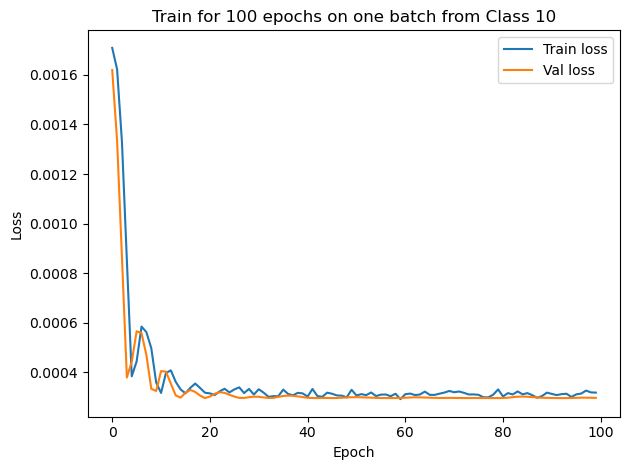

In [20]:
# Plot the losses
%matplotlib inline
plot_losses(torch.asarray(train_losses), torch.asarray(val_losses), title="Train for 100 epochs on one batch from Class 10", save_path=f"../save/plots/{run_name}.png")

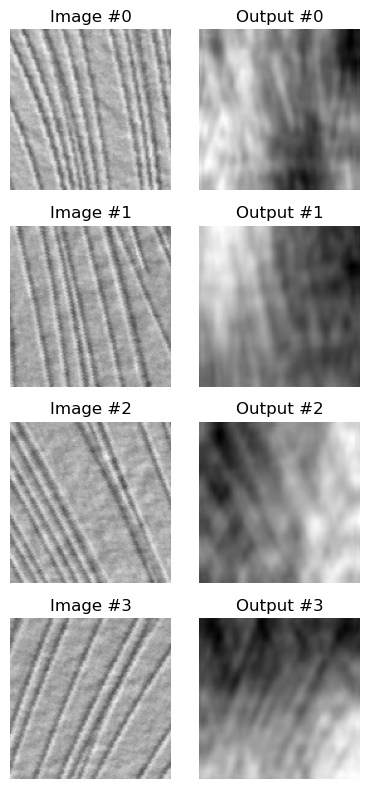

In [15]:
def flatten(xs):
    return [x for ys in xs for x in ys]

images, keys = next(iter(train_dataloader))
input_images = []
outputs = []
for i in range(4):
    image = images[i]
    input_images.append(image.squeeze().detach().cpu().numpy())
    input = image.unsqueeze(0).to(config.device)
    input[48:80, 48:80] = 0
    output = model_best(input)
    outputs.append(output.squeeze().detach().cpu().numpy())
titles = flatten([[f"Image #{i}", f"Output #{i}"] for i in range(4)])
plot_images(flatten(list(zip(input_images, outputs))), titles, rows=4, cols=2, figsize=(4, 8))